In [1]:
import pandas as pd
import yfinance as yf
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import torch
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Sentiment Analysis Data

The data can be downloaded from Kaggle: [Daily Financial News for 6000+ Stocks](https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests/data.). There are three .csv files available for download, each containing news headlines for different stocks along with the corresponding dates. Please note that the dates in two of these .csv files might be inaccurate. As stated on Kaggle: 

- For raw_analyst_ratings.csv: "Note that all dates in this CSV file don't contain exact hour-minute-second information. If you plan on using this file to backtest, assume that the article was published the next day instead of the day shown in the current article."
- For raw_partner_headlines.csv: "For this CSV, it isn't possible to get precise hour-minute-second timestamps for the dates. Follow the same backtesting procedure mentioned for the previous file."

To ensure that the agent only receives news published prior to the market closing, only the analyst_ratings_processed.csv file will be considered. This file contains accurate timestamps: "This file has exact dates down to the minute." Using only the analyst_ratings_processed.csv file might reduce the total number of data points, but it ensures the data's accuracy and reliability.

## Read the data from kaggle

In [3]:
financial_news_headlines = pd.read_csv(
                                r'/Applications/Studium/Master/Masterarbeit/AADRL/data/analyst_ratings_processed.csv', 
                                usecols= ['date','title','stock']
                                )[['date','title','stock']]

As some rows contain different time zones (see below), the first step is to convert them to a specific time zone. Given that yfinance utilizes NYSE as the default stock exchange, the conversion will be to New York Time (UTC-4).

In [4]:
financial_news_headlines.iloc[40:45]

,date,title,stock
40,2020-03-13 08:28:00-04:00,Shares of several basic materials companies ar...,A
41,2020-03-12 12:10:00-04:00,Stocks That Hit 52-Week Lows On Thursday,A
42,2020-03-11 11:51:00-04:00,Shares of several coronavirus-related companie...,A
43,2020-03-03 16:18:00-05:00,"Agilent Technologies Inc Says In January 2020,...",A
44,2020-03-02 11:18:00-05:00,Shares of several healthcare companies are tra...,A


In [5]:
# Copy dataframe (to avoid warnings)
df = financial_news_headlines.copy()

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')

# Drop rows with NaT values (invalid datetime strings) or missing stocks
df = df.dropna(subset=['date','stock'])

# Convert all dates to new york time zone
df.date = df['date'].dt.tz_convert('America/New_York')

## Simple Statistics & Getting the Tickers for Trading

In [6]:
# Get the max date
df.date.max()

Timestamp('2020-06-11 17:12:00-0400', tz='America/New_York')

In [7]:
# Get the min date
df.date.min()

Timestamp('2009-02-14 14:02:00-0500', tz='America/New_York')

In [8]:
# Get the 30 Stocks with the highest occurences within the dataset
stocks = df['stock'].value_counts()[:50]

In [9]:
# Try downloading the data for the different stocks
data = yf.download(
                list(stocks.index),
                start = '2009-01-01', 
                end = '2021-01-01',
                period = '1d'
                )

[*********************100%%**********************]  50 of 50 completed

6 Failed downloads:
['JCP', 'AGN']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['CHK']: YFChartError("%ticker%: Data doesn't exist for startDate = 1230786000, endDate = 1609477200")
['BBRY', 'TWX']: YFInvalidPeriodError("%ticker%: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']")
['P']: YFInvalid%ticker%eriodError("%ticker%: %ticker%eriod '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']")


In [10]:
# Calculate for each ticker the percentage of occurences
col = 'Adj Close'
percentages_data = defaultdict()
for tick in stocks.index:
    percentages_data[tick] = data[col][tick].count()/len(data[col])

In [11]:
# Get 30 tickers where the percentage of population is at least 80%
final_tickers = []
len_tickerlist = 0
for idx, tick in enumerate(percentages_data.keys()):
    if percentages_data[tick] >= 0.8 and len_tickerlist < 30:
        final_tickers.append(tick)
        len_tickerlist +=1

In [12]:
# Print tickers (one can see below, that for each tickere the data is completely populated)
print(final_tickers)

['MRK', 'MS', 'MU', 'NVDA', 'QQQ', 'M', 'EBAY', 'NFLX', 'GILD', 'VZ', 'DAL', 'JNJ', 'QCOM', 'KO', 'ORCL', 'FDX', 'HD', 'WFC', 'BMY', 'LLY', 'CMG', 'CAT', 'FSLR', 'NOK', 'LMT', 'MCD', 'MA', 'EA', 'FCX', 'EWU']


The ticker list contains not only stocks but also ETFs. For example, QQQ (Invesco QQQ Trust Series 1) and EWU (iShares MSCI United Kingdom ETF). Therefore, these ETFs will be replaced with the following stocks in percentages_data.keys()

In [13]:
percentages_data

defaultdict(None,
            {'MRK': 1.0,
             'MS': 1.0,
             'MU': 1.0,
             'NVDA': 1.0,
             'QQQ': 1.0,
             'M': 1.0,
             'EBAY': 1.0,
             'NFLX': 1.0,
             'GILD': 1.0,
             'VZ': 1.0,
             'DAL': 1.0,
             'JNJ': 1.0,
             'QCOM': 1.0,
             'BABA': 0.5239986759351208,
             'KO': 1.0,
             'ORCL': 1.0,
             'FDX': 1.0,
             'HD': 1.0,
             'WFC': 1.0,
             'BBRY': 0.0,
             'BMY': 1.0,
             'JCP': 0.0,
             'LLY': 1.0,
             'AGN': 0.0,
             'CMG': 1.0,
             'CAT': 1.0,
             'GPRO': 0.5435286329030122,
             'TWX': 0.0,
             'CHK': 0.0,
             'FSLR': 1.0,
             'NOK': 1.0,
             'P': 0.0,
             'LMT': 1.0,
             'MCD': 1.0,
             'MA': 1.0,
             'EA': 1.0,
             'FCX': 1.0,
             'EWU': 1.0,
   

In [14]:
# The next stocks are GPS and PEP. Those will erplace EWU and QQQ
final_tickers.remove('QQQ')
final_tickers.remove('EWU')

In [15]:
final_tickers = final_tickers + ['GPS','PEP']

For each ticker, get the company name, the stock exchange, and the currency. It's necessary to ensure that all prices are in the same currency. Additionally, it must be analyzed to which stock exchange the prices refer to ensure that the agent does not receive any financial headlines that that would be published later during trading.

In [16]:
# Get the stock exchanges
stock_exchanges = {stocks: None for stocks in final_tickers}
for ticker in final_tickers:
    info = yf.Ticker(ticker).info 

    try:
        stock_exchanges[ticker] = (info['longName'], info['exchange'], info['currency'])
    except:
        print(ticker)
        
stock_exchanges

{'MRK': ('Merck & Co., Inc.', 'NYQ', 'USD'),
 'MS': ('Morgan Stanley', 'NYQ', 'USD'),
 'MU': ('Micron Technology, Inc.', 'NMS', 'USD'),
 'NVDA': ('NVIDIA Corporation', 'NMS', 'USD'),
 'M': ("Macy's, Inc.", 'NYQ', 'USD'),
 'EBAY': ('eBay Inc.', 'NMS', 'USD'),
 'NFLX': ('Netflix, Inc.', 'NMS', 'USD'),
 'GILD': ('Gilead Sciences, Inc.', 'NMS', 'USD'),
 'VZ': ('Verizon Communications Inc.', 'NYQ', 'USD'),
 'DAL': ('Delta Air Lines, Inc.', 'NYQ', 'USD'),
 'JNJ': ('Johnson & Johnson', 'NYQ', 'USD'),
 'QCOM': ('QUALCOMM Incorporated', 'NMS', 'USD'),
 'KO': ('The Coca-Cola Company', 'NYQ', 'USD'),
 'ORCL': ('Oracle Corporation', 'NYQ', 'USD'),
 'FDX': ('FedEx Corporation', 'NYQ', 'USD'),
 'HD': ('The Home Depot, Inc.', 'NYQ', 'USD'),
 'WFC': ('Wells Fargo & Company', 'NYQ', 'USD'),
 'BMY': ('Bristol-Myers Squibb Company', 'NYQ', 'USD'),
 'LLY': ('Eli Lilly and Company', 'NYQ', 'USD'),
 'CMG': ('Chipotle Mexican Grill, Inc.', 'NYQ', 'USD'),
 'CAT': ('Caterpillar Inc.', 'NYQ', 'USD'),
 'FSLR': (

The main stock exchanges considered are NYSE and NASDAQ. Both exchanges use the UTC-4 timezone, aligning with the timestamps of the news headlines. At each timestep t, the agent will receive all financial news headlines up until 4 PM. Any news released after 4 PM will be included in the next day's state representation. 

At this point, we proceed to calculate the final market data by extracting the tickers mentioned in the dictionary from the previously generated output.

In [17]:
# Get the tickers 
tickers = list(stock_exchanges.keys())

# Get the possible prices
market_data_cols = list(data.columns.get_level_values('Price').unique()) 

# Calculate the combinations between tickers and possible prices (needed since market data has multiindex as columns)
combinations = list(itertools.product(market_data_cols,tickers))

# Get the final data
final_market_data = data[combinations]

In [18]:
# Save the market data as a csv file
final_market_data.to_csv('/Applications/Studium/Master/Masterarbeit/AADRL/data/market_data.csv')

final_market_data

Price       Adj Close                                                          \
Ticker            MRK         MS         MU        NVDA          M       EBAY   
Date                                                                            
2009-01-02  17.348501  12.312318   2.789244    1.997425   6.757350   5.653067   
2009-01-05  17.085478  12.768867   3.260666    2.034118   7.175840   5.695485   
2009-01-06  16.772085  14.189246   3.407985    2.102915   7.194301   5.853585   
2009-01-07  16.503464  13.116714   3.221380    1.976786   6.960440   5.626073   
2009-01-08  16.430712  13.638485   3.349057    1.926335   6.726579   5.656923   
...               ...        ...        ...         ...        ...        ...   
2020-12-24  69.107368  60.685936  69.318604  129.639236   9.780960  47.284370   
2020-12-28  69.374687  60.650303  69.397186  128.703888  10.608931  47.397572   
2020-12-29  70.211174  60.347275  68.955223  129.135361  10.472451  47.982502   
2020-12-30  69.495415  60.463139  70.634659  131.155762  10.945577  47.690037   
2020-12-31  70.538849  61.078091  73.836395  130.250320  10.235889  47.407009   

Price                                                    ...    Volume  \
Ticker            NFLX       GILD         VZ        DAL  ...       CAT   
Date                                                     ...             
2009-01-02    4.267143  19.197586  14.871536  10.676052  ...   7117200   
2009-01-05    4.562857  18.763454  13.944213  10.517627  ...  11098700   
2009-01-06    4.705714  18.259415  13.720971  10.896087  ...  10863400   
2009-01-07    4.672857  17.924622  13.895199  10.456018  ...   9026500   
2009-01-08    4.735714  17.979805  14.108644  10.755266  ...   9384200   
...                ...        ...        ...        ...  ...       ...   
2020-12-24  513.969971  49.885788  48.112282  39.367222  ...    585700   
2020-12-28  519.119995  49.728451  48.226761  39.783390  ...   1508800   
2020-12-29  530.869995  49.676010  48.087749  39.664478  ...   1490300   
2020-12-30  524.590027  49.518658  47.539898  40.189644  ...   2720600   
2020-12-31  540.729980  50.925995  48.038685  39.842838  ...   1717800   

Price                                                                 \
Ticker         FSLR       NOK      LMT       MCD        MA        EA   
Date                                                                   
2009-01-02  3935700   8119200  1696800   8652700  22311000   5874000   
2009-01-05  5865300  11639000  2472800   7692900  24719000   8065000   
2009-01-06  4678500  10237800  2860100  10855700  43357000  17913900   
2009-01-07  3649500  19023100  2860500   7910400  39537000   9376200   
2009-01-08  3878800  16105300  2966100   9382300  22841000   9922900   
...             ...       ...      ...       ...       ...       ...   
2020-12-24  1340600   7298800   508800   1047700   1308900    688100   
2020-12-28  3131700  18694700  1023400   2550100   3449100   1756100   
2020-12-29  2150600  19875400  1055900   1665700   2822700   1188400   
2020-12-30  1727500  17464600   840800   1855000   4200600   1684500   
2020-12-31  1585300  17088900  1318500   2610900   2881700   1689900   

Price                                    
Ticker           FCX       GPS      PEP  
Date                                     
2009-01-02  32276400   4601400  5182400  
2009-01-05  51357800   5926300  7122000  
2009-01-06  70888800  10589700  8081600  
2009-01-07  50379400   9248400  7364600  
2009-01-08  40728000  16068200  8210400  
...              ...       ...      ...  
2020-12-24   5107700   2149900   883300  
2020-12-28  10089500   4569300  2493500  
2020-12-29   9894800   6297100  3186700  
2020-12-30  32167000   4726100  2224900  
2020-12-31  16527900   3468600  2076800  

[3021 rows x 180 columns]

## Adjust Dates of the Financial News Headlines

As previously mentioned, the agent will receive financial news up until 4 PM for each timestep t of the day (NYSE closes at 4 P.M: [NYSE Trading Hours](https://www.nyse.com/markets/nyse-arca/market-info#:~:text=Core%20Trading%20Session%3A%209%3A30,to%204%3A00%20p.m.%20ET). Therefore, the data will be adjusted by mapping the headlines to their corresponding days.

In [19]:
df['date'] = df['date'].apply(
                        lambda x: x.date() + pd.Timedelta(days=1) 
                        if x.hour >= 16 else x.date()
                        )

In [20]:
df

,date,title,stock
0,2020-06-05,Stocks That Hit 52-Week Highs On Friday,A
1,2020-06-03,Stocks That Hit 52-Week Highs On Wednesday,A
2,2020-05-26,71 Biggest Movers From Friday,A
3,2020-05-22,46 Stocks Moving In Friday's Mid-Day Session,A
4,2020-05-22,B of A Securities Maintains Neutral on Agilent...,A
...,...,...,...
1400464,2011-08-29,Top Narrow Based Indexes For August 29,ZX
1400465,2011-06-23,Recap: Wednesday's Top Percentage Gainers and ...,ZX
1400466,2011-06-21,UPDATE: Oppenheimer Color on China Zenix Auto ...,ZX
1400467,2011-06-21,Oppenheimer Initiates China Zenix At Outperfor...,ZX


In [21]:
# Extract the 'relevant' news headlines 
sentiment_texts_processed = df[df['stock'].isin(stock_exchanges.keys())].reset_index(drop = True)

Until now, news headlines that appeared on weekends were treated as "normal." The issue is that the markets are closed on these days. By concatenating the market data with the sentiment data, NaNs will appear in the price history due to the weekends. Therefore, the dates need to be adjusted slightly. If the day/time of the news headline is Saturday, Sunday, or Friday afternoon, we will map it to Monday morning. This way, all preceding news headlines will influence decisions on Monday.

Furthermore, it was observed (later after working with the agent environment) that there are news headlines on market holidays. For example, there is a news headline from May 25, 2020. This day was Memorial Day in the USA, and the NYSE was closed. The headline should therefore be mapped to the next trading day. Since there is no list that contains all the market holidays, but there is a list containing all trading days (see above), a different approach is used. It will be checked whether the date of the financial headline is in the index of the historical price time series. If this is the case, the date of the headline will not be changed. Otherwise, the date will be adjusted to the next date when the market was open and the stock was traded.

In [22]:
# Convert date of sentiment data to timestap
timestamps = list(map(pd.Timestamp, sentiment_texts_processed.date))

# Create list in which the dates will be 
adjusted_dates = [None for i in timestamps]

# Loop over the timestamps
for idx, ts in enumerate(timestamps):
    # Check if for a given date in sentiment analysis, the market was open
    if ts in final_market_data.index:
        # Keep the date fixed, if the market was open
        adjusted_dates[idx] = ts
    # If the market was closed, we need to change the date
    else:
        # Find the next date in final_market_data index
        next_date_idx = final_market_data.index.searchsorted(ts)
        adjusted_dates[idx] = final_market_data.index[next_date_idx]

In [23]:
sentiment_texts_processed.date = adjusted_dates

In [24]:
# The sentiments now refer to the correct dates
sentiment_texts_processed

,date,title,stock
0,2020-06-09,UbiVac Reports Trial Collaboration With Bristo...,BMY
1,2020-06-04,Jounce Therapeutics Regains Worldwide Rights T...,BMY
2,2020-06-04,Traders Share Their Health Care Picks,BMY
3,2020-06-03,The Daily Biotech Pulse: Regulatory Delay For ...,BMY
4,2020-06-03,Bristol Myers Squibb Highlights New Data Reinf...,BMY
...,...,...,...
79204,2012-01-05,Bank of America Up Better Than 4%,WFC
79205,2012-01-03,New Fed Transparency Buys Time For The Stock M...,WFC
79206,2012-01-03,Will GE Make You Money in 2012?,WFC
79207,2011-12-28,Best Utilities Stocks of 2011,WFC


We will adopt the approach as described in "Deep Reinforcement Learning Approach for Trading Automation in the Stock Market" by Kabbani and Duman to calculate the sentiment scores. For each news headline, the sentiment score will be computed using FinBert, and subsequently, the mean value will be calculated for each day. (For instructions on how to use the (Fin)Bert model, refer to the documentation at [BertForSequenceClassification](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForSequenceClassificatio) and [FinBert](https://huggingface.co/ProsusAI/finbert?library=transformers))

In [25]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/Applications/Studium/Master/Masterarbeit/AADRL/.venv_AADRL/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Example on how to use FinBert

In [26]:
# Tokenize the sentence
inputs = tokenizer('Return and gross revenue decreased by 50%', return_tensors='pt')

# Get the logits (output of DNN before applying softmax)
logits = model(**inputs).logits

# Apply softmax to get the probability for each sentiment (as stated in Huggingface: the model ouputs the labels: positive, negative or neutral)
probabilities = F.softmax(logits, dim=-1)

probabilities

tensor([[0.0093, 0.9728, 0.0180]], grad_fn=<SoftmaxBackward0>)

In [27]:
# Function to calculate sentiment and probability
def get_sentiment(text):
    """
    Calculate for a given text the sentiment label and the
    probability using FinBert

    Params:
        - text (str): text that one wants to calculate the 
        sentiment score
    """

    # Tokenize the text and calculate the logits
    inputs = tokenizer(text, return_tensors='pt')
    logits = model(**inputs).logits

    # Get the probabilities by applying softmax layer
    probabilities = F.softmax(logits, dim=-1)

    # Get the sentiment 
    sentiment = torch.argmax(probabilities).item()
    sentiment_labels = ['positive', 'negative', 'neutral']
    sentiment_label = sentiment_labels[sentiment]
    sentiment_probability = probabilities[0, sentiment].item()
    
    # Return the label with the corresponding probability
    return sentiment_label, sentiment_probability

In [28]:
# Create empty list for the labels and probabilities
labels, probabilities = [None for _ in sentiment_texts_processed.index], [None for _ in sentiment_texts_processed.index]

# Loop over the titels
for idx, sent in enumerate(sentiment_texts_processed['title']):
    # Get the label and the corresponding probability
    label, prob = get_sentiment(sent)

    # Save the label and probability
    labels[idx] = label 
    probabilities[idx] = prob

    # Output the index to check at which point the method is
    if (idx+1) % 100 == 0:
        print(idx + 1)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [29]:
# Add new columns containing the sentiment and the corresponding probability for each financial news headline
sentiment_texts_processed['sentiment'] = labels
sentiment_texts_processed['probability_sentiment'] = probabilities

In [30]:
# Save dataframe as csv file so that it does not need to recalculate everything
sentiment_texts_processed.to_csv('/Applications/Studium/Master/Masterarbeit/AADRL/data/sentiment_processed.csv')

Using the previous dataframe, one can compute the sentiment score for each ticker and day. A similar approach as described in "Deep Reinforcement Learning Approach for Trading Automation in the Stock Market" will be adopted:

- Group by ticker, date, and sentiment, then calculate the mean over the probabilities: On any given day, multiple news articles could pertain to a single stock, resulting in both positive and negative sentiments. To address this, the mean probabilities for each sentiment within each group will be calculated first. Afterwards, the daily sentiment will be the sentiment which has the highest probability.

It's worth noting that in the aforementioned article, neutral sentiments were disregarded and only considered when there were no news articles for the given date. However, this approach is not being implemented here. The authors assumed that news articles could not have a neutral effect on stock prices. While this assumption could be empirically analyzed, it's important to acknowledge that the FinBert model, trained for sentiment classification of FINANCIAL NEWS HEADLINES, classifies sentiments into positive, neutral, or negative categories. If news articles truly couldn't have a neutral effect, the model might have been designed for binary classification (e.g., positive or negative) only. All in all, this could be a potential research question and further analyzed.

In [31]:
# Group by date, stock and sentiment and calculate the mean probability
sentiment_grouped = sentiment_texts_processed[['date','stock','sentiment','probability_sentiment']].groupby(['date','stock','sentiment']).mean()

In [32]:
sentiment_grouped

probability_sentiment
date       stock sentiment                       
2009-06-16 M     neutral                 0.900430
2009-06-23 KO    neutral                 0.600840
2009-07-27 MRK   neutral                 0.925613
2009-08-06 M     negative                0.610491
2009-08-07 GPS   neutral                 0.815911
...                                           ...
2020-06-11 VZ    negative                0.972277
           WFC   negative                0.943404
                 neutral                 0.922024
                 positive                0.575701
2020-06-12 WFC   neutral                 0.939551

[47282 rows x 1 columns]

In [33]:
# Get for each date and stock the indeces with the highest probability 
idx = sentiment_grouped.groupby(['date', 'stock'])['probability_sentiment'].idxmax()

In [34]:
# Based on the previous indeces, we get the rows with the highest probabilities
df_max_sentiment = sentiment_grouped.loc[idx]
most_probable_sentiment = df_max_sentiment.reset_index() 

# Check: One can see that we get the correct results (see stock: WFC, date: 2020-06-11)
most_probable_sentiment

,date,stock,sentiment,probability_sentiment
0,2009-06-16,M,neutral,0.900430
1,2009-06-23,KO,neutral,0.600840
2,2009-07-27,MRK,neutral,0.925613
3,2009-08-06,M,negative,0.610491
4,2009-08-07,GPS,neutral,0.815911
...,...,...,...,...
33667,2020-06-11,ORCL,negative,0.973734
33668,2020-06-11,PEP,negative,0.973434
33669,2020-06-11,VZ,negative,0.972277
33670,2020-06-11,WFC,negative,0.943404


In [35]:
# Encode the sentiments as numbers
most_probable_sentiment = most_probable_sentiment[['date','stock','sentiment']].replace(
                                                                                {'neutral': 0,
                                                                                'positive': 1,
                                                                                'negative': -1}
                                                                                )

/var/folders/cp/6hchgv613zxclnc7zyc9qbcc0000gn/T/ipykernel_53103/2181127287.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  most_probable_sentiment = most_probable_sentiment[['date','stock','sentiment']].replace(


In [36]:
most_probable_sentiment

,date,stock,sentiment
0,2009-06-16,M,0
1,2009-06-23,KO,0
2,2009-07-27,MRK,0
3,2009-08-06,M,-1
4,2009-08-07,GPS,0
...,...,...,...
33667,2020-06-11,ORCL,-1
33668,2020-06-11,PEP,-1
33669,2020-06-11,VZ,-1
33670,2020-06-11,WFC,-1


In [37]:
# Distribution of positive, negative and neutral news headlines
distribution_sentiments = most_probable_sentiment['sentiment'].value_counts().sort_index()
distribution_sentiments

sentiment
-1     6710
 0    18684
 1     8278
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

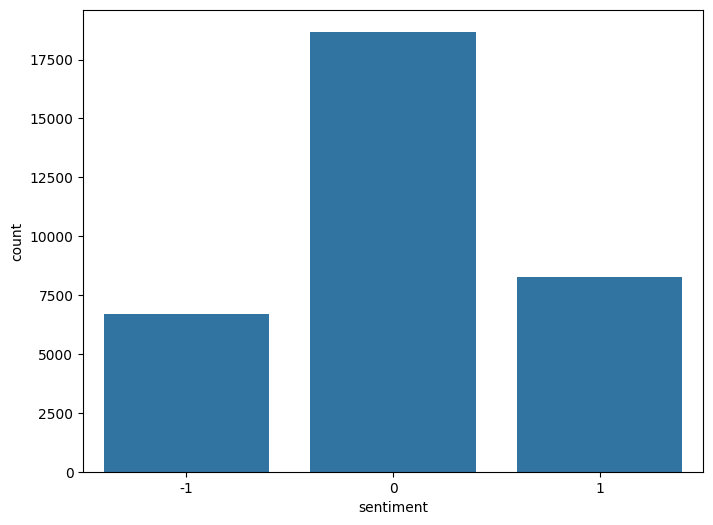

In [38]:
# Count total number of positive, negative and neutral sentiments
sentiment_counts = most_probable_sentiment['sentiment'].value_counts().sort_index().reset_index()
sentiment_counts.columns = ['sentiment', 'count']

# Create the seaborn bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment', y='count', data=sentiment_counts)

In [39]:
# Save the final processed sentiment file as a csv file
most_probable_sentiment.to_csv('/Applications/Studium/Master/Masterarbeit/AADRL/data/stock_sentiments_final.csv')

-----------------

### Further statistical Analysis (Added After Training) ###


In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import collections
import colorcet as cc
from pingouin import multivariate_normality 
from scipy.stats import kendalltau

#### Recreate Distribution of Sentiments 

In [41]:
# Read the final sentiments file
df = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/stock_sentiments_final.csv',index_col=0)

In [42]:
# Decode from int to sentiment
df_adjusted = df.copy()
df_adjusted['sentiment'] =df_adjusted['sentiment'].replace({0:'neutral',1:'positiv',-1:'negativ'})

Text(0, 0.5, 'Anzahl')

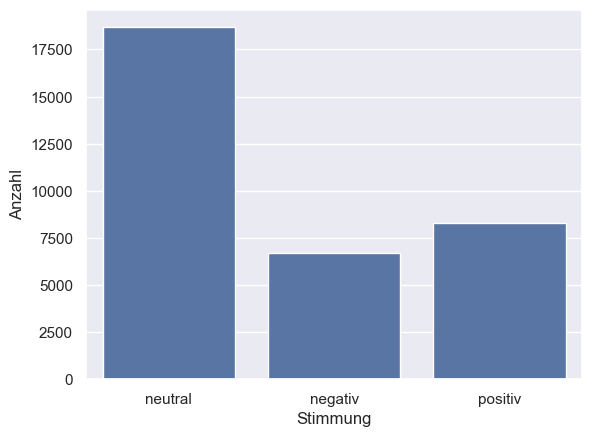

In [43]:
# Create plot
sns.set_theme()
sns.countplot(x='sentiment', data= df_adjusted)
plt.xlabel('Stimmung')
plt.ylabel('Anzahl')

Text(0, 0.5, 'Anzahl')

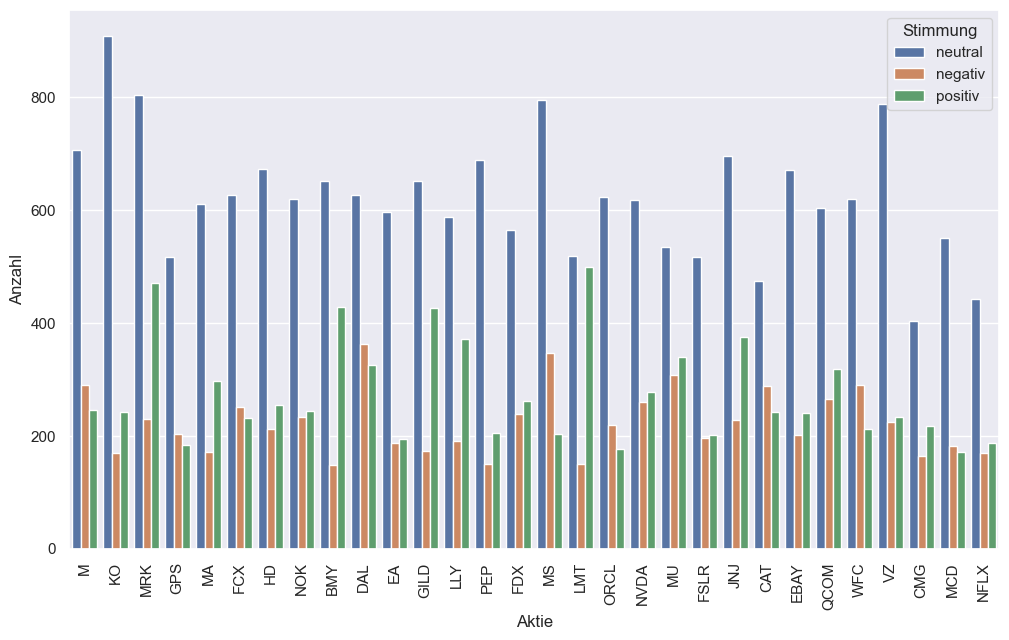

In [44]:
# Create for each ticker the distribution of the sentiments
plt.figure(figsize=(12, 7))
sns.countplot(data=df_adjusted.rename(columns={'sentiment':'Stimmung'}), x='stock', hue='Stimmung')
plt.xticks(rotation=90)
plt.xlabel('Aktie')
plt.ylabel('Anzahl')

#### Statistics of unprocessed sentiment data 

In [45]:
# Read the data
sentiments = pd.read_csv(
                        r'/Applications/Studium/Master/Masterarbeit/AADRL/data/analyst_ratings_processed.csv', 
                        usecols= ['date','title','stock']
                        )
market_data = pd.read_csv('/Applications/Studium/Master/Masterarbeit/AADRL/data/market_data.csv',header=[0,1],index_col=0)

In [46]:
# Adjust dates of the sentiments (as doeo above)
sentiments_adj = sentiments.copy()
sentiments_adj['date'] = pd.to_datetime(sentiments_adj['date'], utc=True, errors='coerce')
sentiments_adj = sentiments_adj.dropna(subset=['date','stock'])
sentiments_adj.date = sentiments_adj['date'].dt.tz_convert('America/New_York')

In [47]:
sentiments

,title,date,stock
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A
...,...,...,...
1400464,Top Narrow Based Indexes For August 29,2011-08-29 10:41:00-04:00,ZX
1400465,Recap: Wednesday's Top Percentage Gainers and ...,2011-06-22 16:44:00-04:00,ZX
1400466,UPDATE: Oppenheimer Color on China Zenix Auto ...,2011-06-21 08:26:00-04:00,ZX
1400467,Oppenheimer Initiates China Zenix At Outperfor...,2011-06-21 05:59:00-04:00,ZX


In [48]:
sentiments['date'] = pd.to_datetime(sentiments_adj['date'], utc=True, errors='coerce')

In [49]:
# Earliest and latest date full dataset
print('Earliest date:', sentiments.date.min(), 'Latest date: ', sentiments.date.max())

Earliest date: 2009-02-14 19:02:00+00:00 Latest date:  2020-06-11 21:12:00+00:00


In [50]:
# Get the unique tickers in market data
unique_columns_second_level = market_data.columns.get_level_values('Ticker').unique()

In [51]:
# Earliest date on subset of stocks
print(
    'Earliest date: ', sentiments_adj[sentiments_adj['stock'].isin(unique_columns_second_level)].date.min(),
    'Latest date: ', sentiments_adj[sentiments_adj['stock'].isin(unique_columns_second_level)].date.max()
    )

Earliest date:  2009-06-16 08:14:00-04:00 Latest date:  2020-06-11 17:12:00-04:00


In [52]:
# Save the subset of dataframe containing the sentiments of the imporant stocks
subset_stocks = sentiments_adj[sentiments_adj['stock'].isin(unique_columns_second_level)].reset_index(drop=True)

# Get the latest article
print('Latest article', subset_stocks.iloc[subset_stocks.date.idxmax()], 'Earliest article: ', subset_stocks.iloc[subset_stocks.date.idxmin()])

# Note: Latest date is after 5 P.M. There it will be mapped to the next trading day (which is the 12.06.2020 in this case)

Latest article title    Quicken Loans Plans To IPO: Report
date              2020-06-11 17:12:00-04:00
stock                                   WFC
Name: 76597, dtype: object Earliest article:  title    AIM Great News the Day After Great Earnings
date                       2009-06-16 08:14:00-04:00
stock                                              M
Name: 43443, dtype: object


#### Statistics of the stocks

In [53]:
# Get the distribution and the industry of each ticker (can be downloaded)
# directly from yahoo finance

# Create empty lists to store the value
sectors = []
industries = []

# Loop over the ticker and append the sector and industry
for tick in unique_columns_second_level:
    sector=(yf.Ticker(tick).info)["sector"]
    industry=(yf.Ticker(tick).info)["industry"]
    print(f'Ticker : {tick}, Sector: {sector}, Industry: {industry}')
    sectors.append(sector)
    industries.append(industry)

Ticker : MRK, Sector: Healthcare, Industry: Drug Manufacturers - General
Ticker : MS, Sector: Financial Services, Industry: Capital Markets
Ticker : MU, Sector: Technology, Industry: Semiconductors
Ticker : NVDA, Sector: Technology, Industry: Semiconductors
Ticker : M, Sector: Consumer Cyclical, Industry: Department Stores
Ticker : EBAY, Sector: Consumer Cyclical, Industry: Internet Retail
Ticker : NFLX, Sector: Communication Services, Industry: Entertainment
Ticker : GILD, Sector: Healthcare, Industry: Drug Manufacturers - General
Ticker : VZ, Sector: Communication Services, Industry: Telecom Services
Ticker : DAL, Sector: Industrials, Industry: Airlines
Ticker : JNJ, Sector: Healthcare, Industry: Drug Manufacturers - General
Ticker : QCOM, Sector: Technology, Industry: Semiconductors
Ticker : KO, Sector: Consumer Defensive, Industry: Beverages - Non-Alcoholic
Ticker : ORCL, Sector: Technology, Industry: Software - Infrastructure
Ticker : FDX, Sector: Industrials, Industry: Integrated

In [54]:
# Dictionary to translate the yahoo finance sector into german 
sector_translation = {
    'Healthcare': 'Gesundheitswesen',
    'Financial Services': 'Finanzdienstleister',
    'Technology': 'Technologie',
    'Consumer Cyclical': 'Zyklischer Konsum',
    'Communication Services': 'Kommunikationsdienste',
    'Industrials': 'Industrie',
    'Consumer Defensive': 'Stabiler Konsum',
    'Basic Materials': 'Grundmaterialien' 
}

translated_sectors = [sector_translation[sector] for sector in sectors]

# Count how many different sectors there are
sector_counts = collections.Counter(translated_sectors)

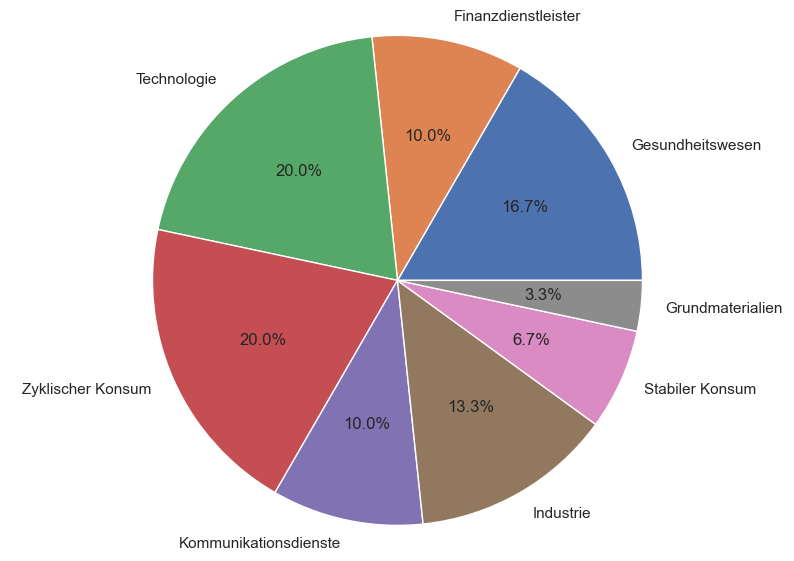

In [55]:
# Create labels and sizes for pie hart
labels = sector_counts.keys()
sizes = sector_counts.values()

# Create pie chart
plt.figure(figsize=(10,7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0)
plt.axis('equal');

#### Statistics of processed sentiment data 

In [56]:
# Read the processed sentiment data
sentiments_processed = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/sentiment_processed.csv', index_col=0)

In [57]:
sentiments_processed

,date,title,stock,sentiment,probability_sentiment
0,2020-06-09,UbiVac Reports Trial Collaboration With Bristo...,BMY,positive,0.764715
1,2020-06-04,Jounce Therapeutics Regains Worldwide Rights T...,BMY,neutral,0.684920
2,2020-06-04,Traders Share Their Health Care Picks,BMY,neutral,0.865215
3,2020-06-03,The Daily Biotech Pulse: Regulatory Delay For ...,BMY,neutral,0.703032
4,2020-06-03,Bristol Myers Squibb Highlights New Data Reinf...,BMY,positive,0.955024
...,...,...,...,...,...
79204,2012-01-05,Bank of America Up Better Than 4%,WFC,positive,0.876139
79205,2012-01-03,New Fed Transparency Buys Time For The Stock M...,WFC,neutral,0.866305
79206,2012-01-03,Will GE Make You Money in 2012?,WFC,neutral,0.904949
79207,2011-12-28,Best Utilities Stocks of 2011,WFC,neutral,0.865984


In [58]:
# Earliest date
sentiments_processed.date.min()

'2009-06-16'

In [59]:
# Latest date
sentiments_processed.date.max()

'2020-06-12'

#### Further analysis of the stocks

In [60]:
# Get the complete market data
market_data_final = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/agent_environment_data.csv',index_col=0,header=[0,1])
close_prices =market_data_final['Adj Close']

In [61]:
### Get the training, validation and testing market data ###
market_data_training = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/training/market_data.csv',index_col=0,header=[0,1])
close_prices_training =market_data_training['Adj Close']

market_data_val = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/validation/market_data.csv',index_col=0,header=[0,1])
close_prices_val = market_data_val['Adj Close']

market_data_test = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/testing/market_data.csv',index_col=0,header=[0,1])
close_prices_test = market_data_test['Adj Close']

##### Heatmaps of Correlation Structure (Pearson & Kendall)

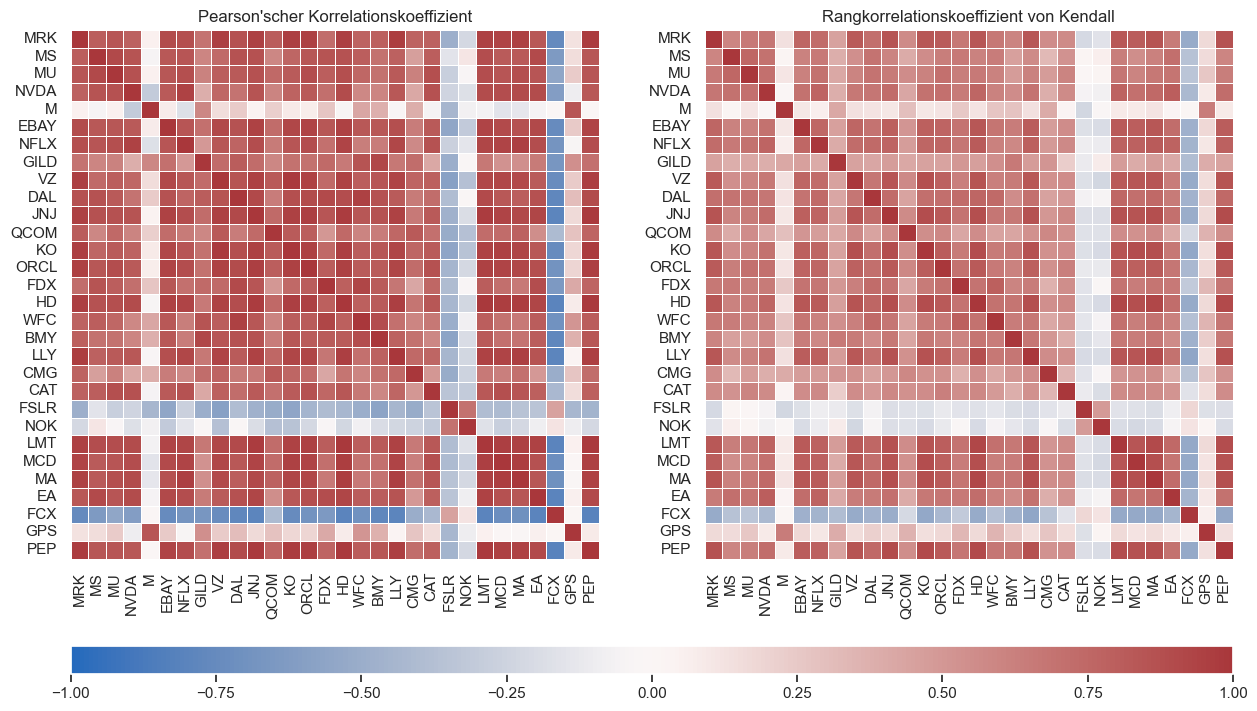

In [62]:
# Create subplot
fig, ax = plt.subplots(figsize=(15,11),ncols=2, nrows = 1)

# Define the palette
palette = sns.color_palette("vlag", as_cmap=True)

# Loop over the method to calculate the correlation
for i,method in enumerate(['pearson','kendall']):
    corrmat = close_prices.corr(method=method)
    # Create heatmap
    sns.heatmap(data=corrmat,
                cmap=palette, 
                vmin=-1,vmax=1,
                linewidths=0.5, 
                fmt=".2f", 
                cbar=False,
                square=True, ax = ax[i])
    

ax[0].set_title("Pearson'scher Korrelationskoeffizient")
ax[1].set_title("Rangkorrelationskoeffizient von Kendall")

# Add a color bar below the heatmaps
cbar_ax = fig.add_axes([0.125, 0.15, 0.775, 0.025])  # [x, y, width, height]
norm = plt.Normalize(vmin=-1, vmax=1)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=sns.color_palette("vlag", as_cmap=True)), 
                    cax=cbar_ax, orientation='horizontal')

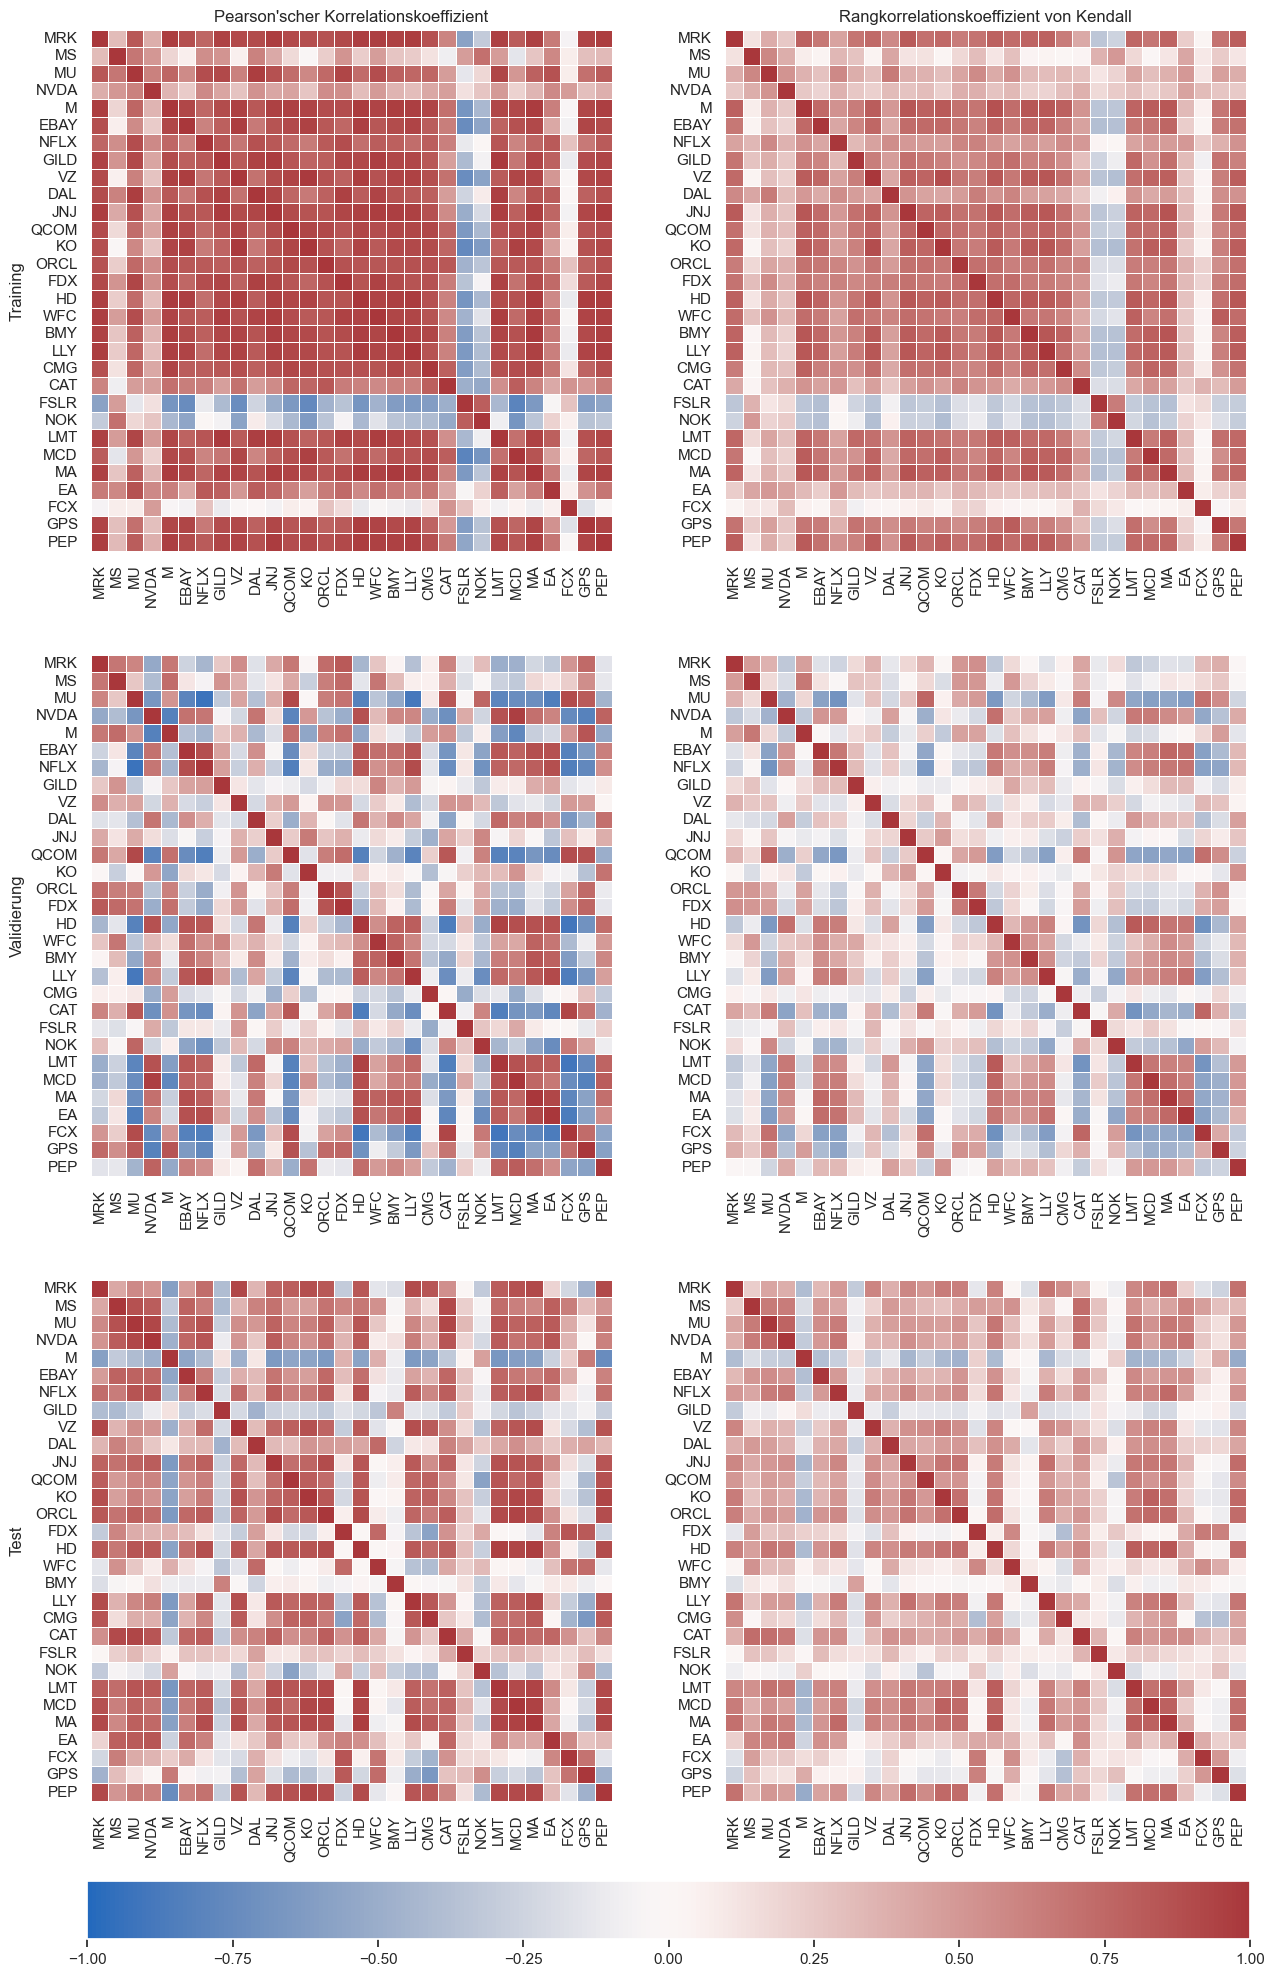

In [63]:
# Create subplots (2 columns for the two correlation methods, and 3 rows for the different datasets)
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(15, 23))  # Increase the figsize)

# Loop over correlation methods
for col,method in enumerate(['pearson','kendall']):
    # Loop over the different close prices
    for i,close_price in enumerate([close_prices_training, close_prices_val, close_prices_test]):
        # Plot heatmap
        sns.heatmap(data=close_price.corr(method=method),
                    cmap=sns.color_palette("vlag", as_cmap=True), 
                    linewidths=0.5, 
                    vmin=-1, vmax=1,
                    cbar=False,
                    square=True, ax = ax[i][col])

# Adjust the y labels (to display which dataset)
ax[0][0].set_ylabel('Training')
ax[1][0].set_ylabel('Validierung')
ax[2][0].set_ylabel('Test')

# Adjust the titles of the columns
ax[0][0].set_title("Pearson'scher Korrelationskoeffizient")
ax[0][1].set_title("Rangkorrelationskoeffizient von Kendall")

# Add a color bar below the heatmaps
cbar_ax = fig.add_axes([0.125, 0.05, 0.775, 0.025])  # [x, y, width, height]
norm = plt.Normalize(vmin=-1, vmax=1)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=sns.color_palette("vlag", as_cmap=True)), 
                    cax=cbar_ax, orientation='horizontal')


To test if the correlation matrices differ significantly, the jennrich test can be used. The assumption of the test is that the samples are drawn from a multivariate normal distribution. Thus, we check this assumption first

In [64]:
print(multivariate_normality(close_prices_training,alpha=0.05))
print(multivariate_normality(close_prices_val,alpha=0.05))
print(multivariate_normality(close_prices_test,alpha=0.05))

# The results show, that the samples are *not* normally distributed. The jennrich test can therefore not be used
# Nevertheless, the plots already suggest that the correlation structure changes over the diffferent datsets

# Instead of looking at the whole correlation matrix, a pairwise test for the correlation structure will be done

HZResults(hz=2.5508959474808615, pval=0.0, normal=False)
HZResults(hz=1.1564726924479978, pval=0.0, normal=False)
HZResults(hz=2.55307037260643, pval=0.0, normal=False)


Calculate pairwise p-value to test if the kendall-tau is statistically different than 0.

In [65]:
# Create empty matrix to store the p-values 
p_value_matrix = pd.DataFrame(np.zeros((close_prices.shape[1], close_prices.shape[1])), 
                              columns=close_prices.columns, index=close_prices.columns)

# Loop over the columns of the dataframe
for col1 in close_prices.columns:
    for col2 in close_prices.columns:
        # Calculate p-value and save it in the matrix
        if col1 != col2:
            tau, p_value = kendalltau(close_prices[col1], close_prices[col2], method='asymptotic')
            p_value_matrix.loc[col1, col2] = p_value

        # On diagional entry we will just 
        else:
            p_value_matrix.loc[col1, col2] = 0

In [66]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colormap
colors = [
    (0, "green"),     
    (0.05, "green"),  
    (0.05, "yellow"), 
    (0.1, "yellow"),  
    (0.1, "red"),     
    (1, "red")        
]

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

Text(0.5, 1.0, 'p-Werte der Hypothentests über die Zusammenhänge zwischen den Aktien')

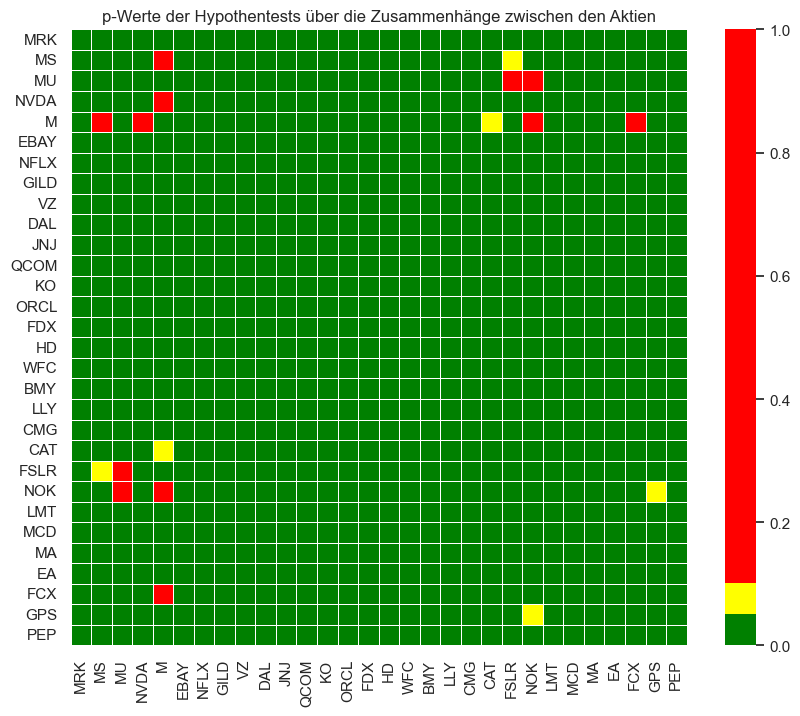

In [67]:
plt.figure(figsize=(10, 8))

# Apply defined colormap to the heatmap
# Note: H0: There is no relationship -> if p-value high, we accept H0 (these fields are marked as red)
sns.heatmap(data=p_value_matrix,
            cmap=custom_cmap, 
            linewidths=0.5, 
            vmin=0, vmax=1,
            cbar=True,
            square=True)

plt.title("p-Werte der Hypothentests über die Zusammenhänge zwischen den Aktien")

In [68]:
# Get all p-values that have an entry bigger than 10% -> independent
pval_red = p_value_matrix[p_value_matrix > 0.1].stack().reset_index()

# Sort (so that order of pairs does not matter: relationship between M-FCX is the same aas FCX-M)
pval_red['sorted_pair'] = pval_red.apply(
                                        lambda row: tuple(sorted([row['level_0'], row['level_1']])), 
                                        axis=1
                                        )

# Drop duplicate pairs & extract the unique pairs
unique_pairs = pval_red.drop_duplicates(subset=['sorted_pair'])
unique_pairs = unique_pairs['sorted_pair'].tolist()

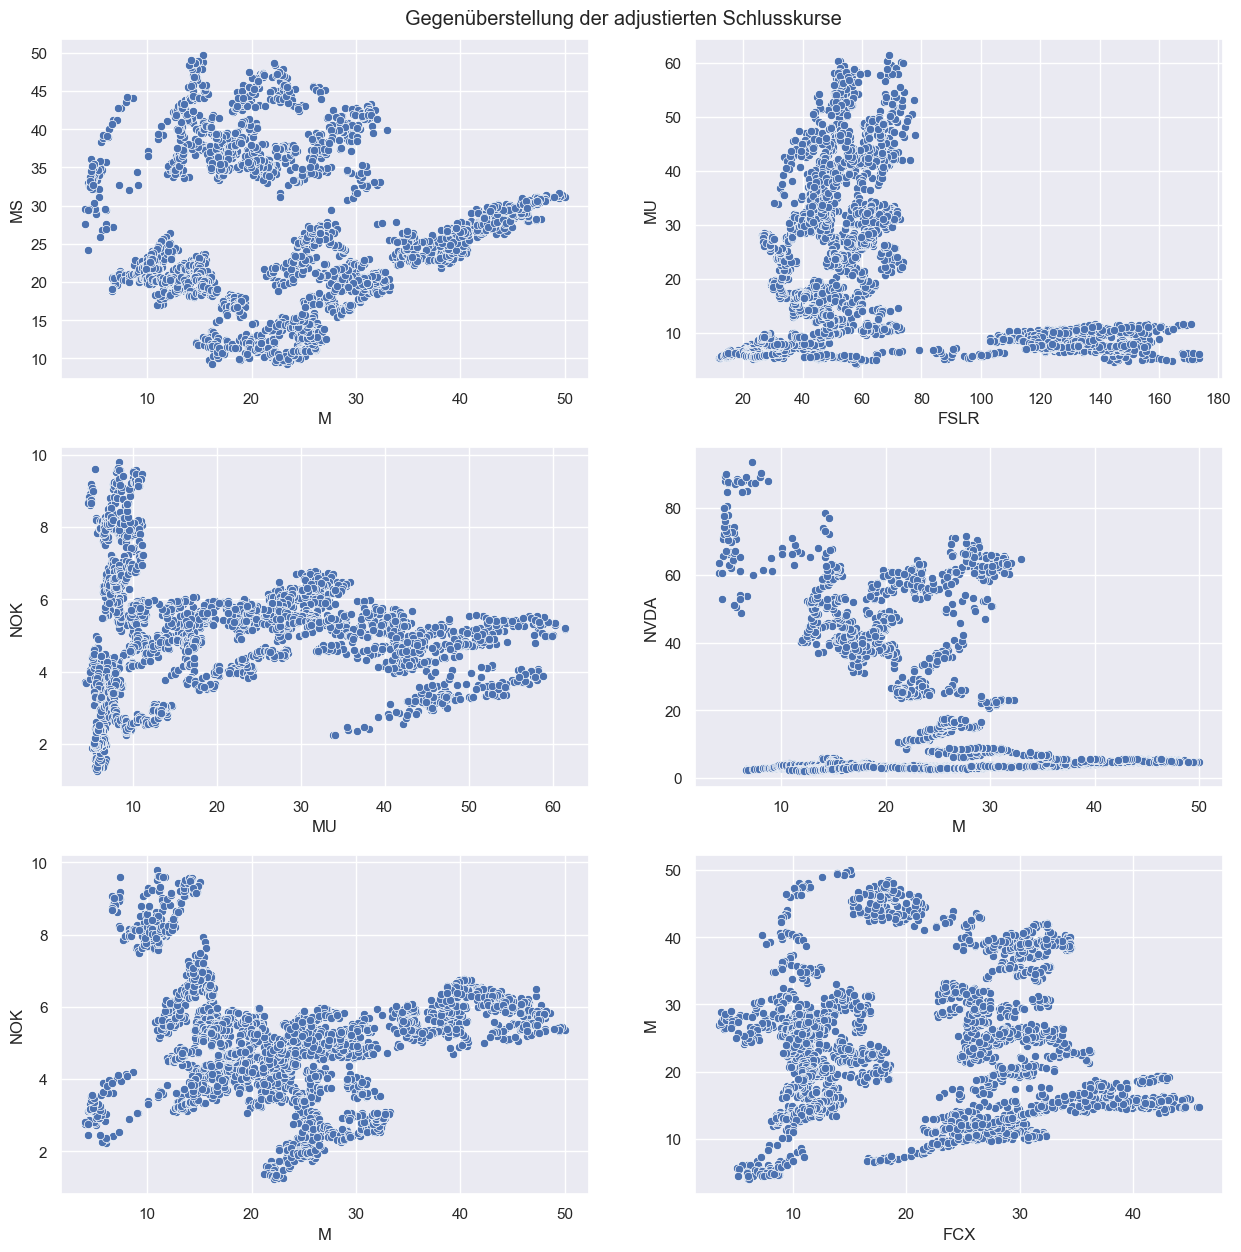

In [69]:
# Create multiple subplots
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

col = 0
row = 0

# Loop over the unique pairs and create pairplots
for i,(ticker_first, ticker_second) in enumerate(unique_pairs):
    # Scatterplot to see the relationship between the adjusted close prices
    sns.scatterplot(
                data=close_prices, 
                x=ticker_first, 
                y=ticker_second, 
                ax=ax[row][col]
                )

    # Update row and col
    col += 1
    if col >= 2:  # Assuming 2 columns
        col = 0
        row += 1
    if row >= 3:  # Assuming 3 rows
        break

plt.suptitle('Gegenüberstellung der adjustierten Schlusskurse',y=0.9);


Plot return at each timestep for each stock

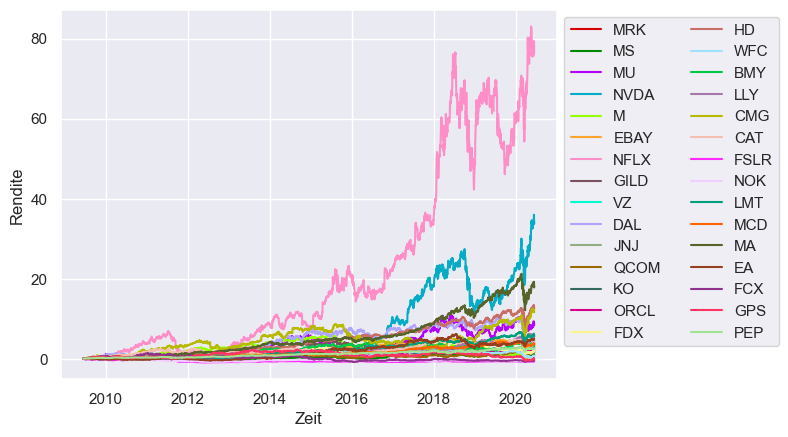

In [70]:
# Define palette
colors = sns.color_palette(cc.glasbey_light, n_colors=30)

# Loop over dataframe and plot the prices
for col,color in zip(close_prices.columns,colors):
    plt.plot(
        pd.to_datetime(close_prices.index),
        close_prices[col]/close_prices[col].iloc[0] - 1, 
        label=col,color=color
        )

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.ylabel('Rendite')
plt.xlabel('Zeit');